# BBC News Classification Kaggle Mini-Project

**==============================================================**

## Project Description / Business Task

This Kaggle competition is about categorizing news articles. You will use matrix factorization to predict the category and submit your notebook for peer evaluation. 

## Data Dictionary

File descriptions

    BBC News Train.csv - the training set of 1490 records
    BBC News Test.csv - the test set of 736 records
    BBC News Sample Solution.csv - a sample submission file in the correct format

Data fields

    ArticleId - Article id unique # given to the record
    Article - text of the header and article
    Category - cateogry of the article (tech, business, sport, entertainment, politics 

**======================================================**

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from wordcloud import WordCloud

import datetime
from datetime import datetime, timedelta, date

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split as surprise_train_test_split
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

%matplotlib inline
#sets the default autosave frequency in seconds
%autosave 60 
sns.set_style('dark')
sns.set(font_scale=1.2)
#sns.set(rc={'figure.figsize':(14,10)})

plt.rc('axes', titlesize=9)
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns',None)
#pd.set_option('display.max_rows',None)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format','{:.2f}'.format)

random.seed(0)
np.random.seed(0)
np.set_printoptions(suppress=True)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dennis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dennis\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dennis\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Dennis\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Autosaving every 60 seconds


**========================================**

## Import Data

In [2]:
df = pd.read_csv("BBC News Train.csv")

In [3]:
df.head()

ArticleId                                               Text  Category
0       1833  worldcom ex-boss launches defence lawyers defe...  business
1        154  german business confidence slides german busin...  business
2       1101  bbc poll indicates economic gloom citizens in ...  business
3       1976  lifestyle  governs mobile choice  faster  bett...      tech
4        917  enron bosses in $168m payout eighteen former e...  business

**=================================================================**

## Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB


In [5]:
df.dtypes.value_counts()

object    2
int64     1
dtype: int64

In [6]:
df.columns

Index(['ArticleId', 'Text', 'Category'], dtype='object')

In [7]:
df.shape

(1490, 3)

In [8]:
df.isnull().sum()

ArticleId    0
Text         0
Category     0
dtype: int64

In [9]:
df.duplicated().sum()

0

**==========================================================================================================**

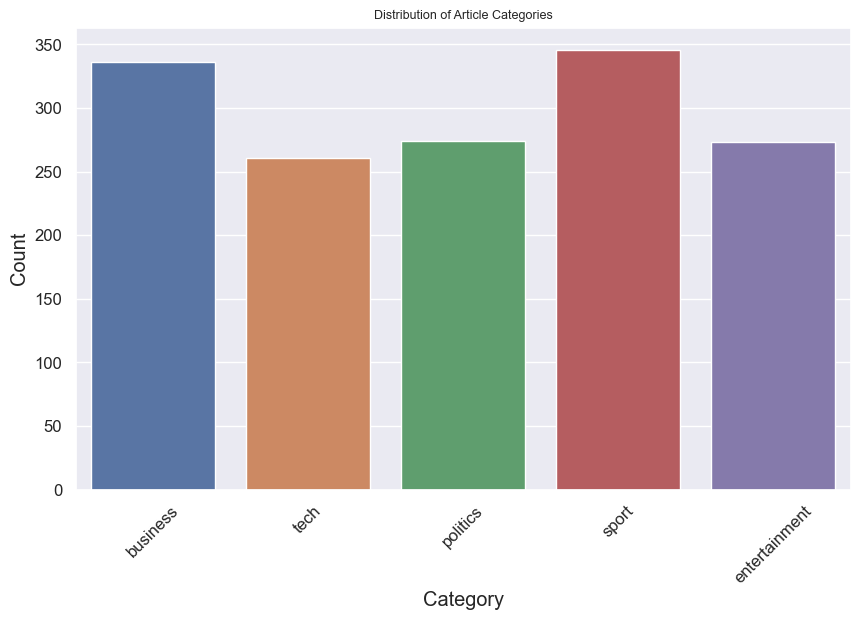

In [10]:
# Distribution of categories
plt.figure(figsize=(10, 6))
sns.countplot(x='Category', data=df)
plt.title('Distribution of Article Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


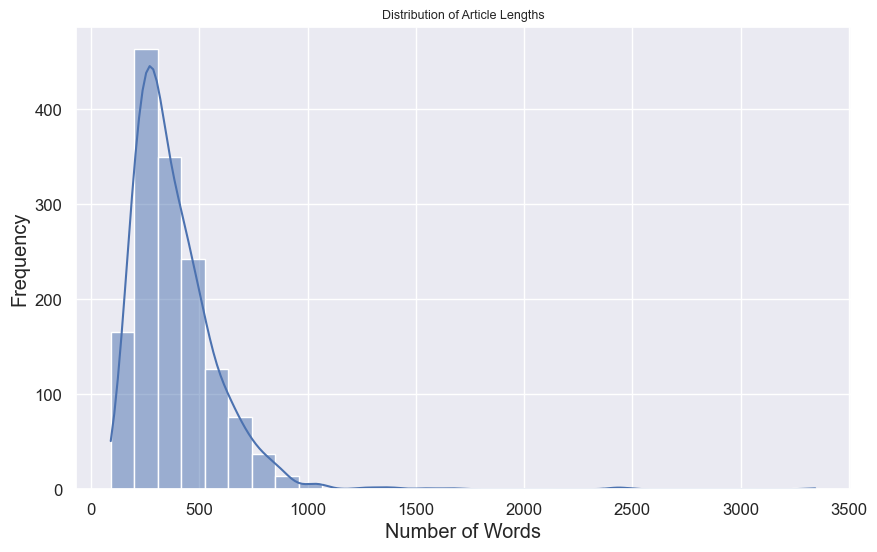

In [11]:
# Add a column for article length
df['Article_Length'] = df['Text'].apply(lambda x: len(x.split()))

# Plot histogram of article lengths
plt.figure(figsize=(10, 6))
sns.histplot(df['Article_Length'], bins=30, kde=True)
plt.title('Distribution of Article Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()


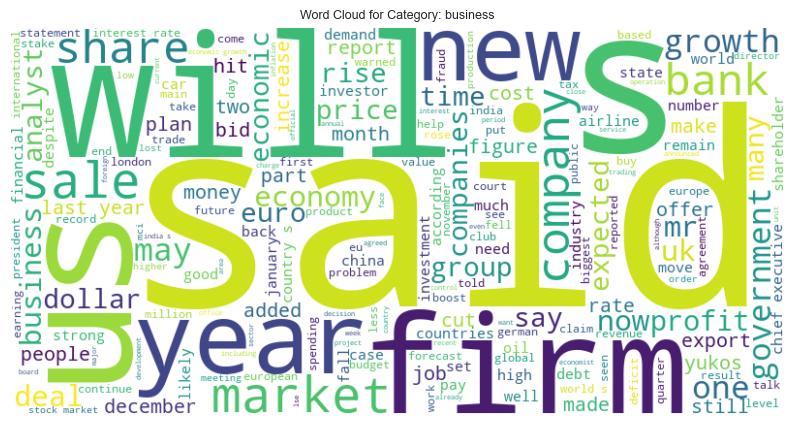

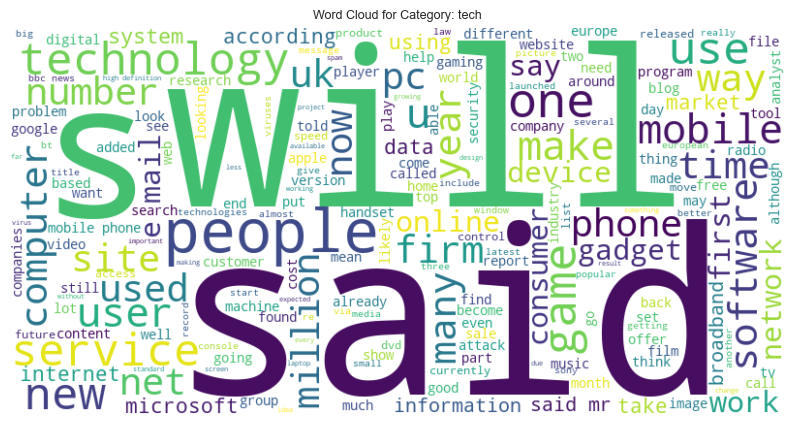

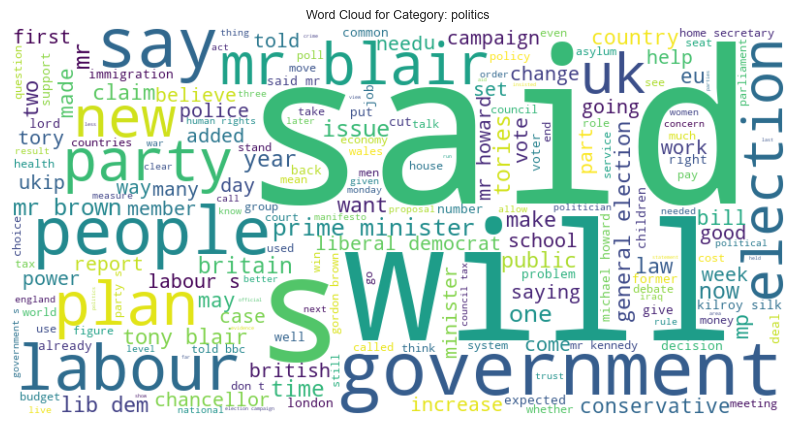

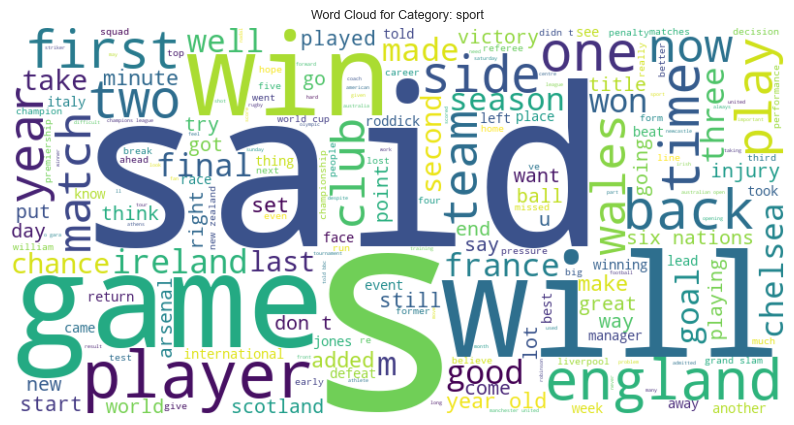

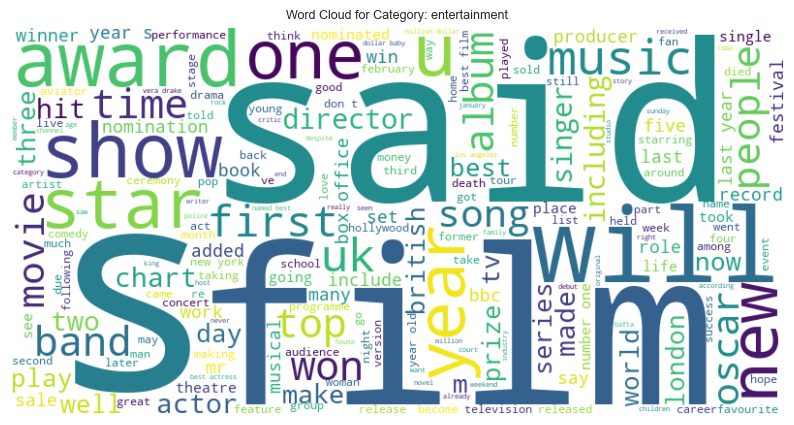

In [12]:
# Function to plot word cloud
def plot_word_cloud(category):
    text = ' '.join(df[df['Category'] == category]['Text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for Category: {category}')
    plt.axis('off')
    plt.show()

# Plot word cloud for each category
for category in df['Category'].unique():
    plot_word_cloud(category)


**==========================================================================================================**

### Load and Preprocess the Data

In [13]:
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word.lower()) for word in tokens if word.isalpha() and word.lower() not in stop_words]
    return ' '.join(tokens)

In [14]:
df['Processed_Text'] = df['Text'].apply(preprocess_text)

In [15]:
df.head()

ArticleId                                               Text  Category  Article_Length                                     Processed_Text
0       1833  worldcom ex-boss launches defence lawyers defe...  business             301  worldcom launch defence lawyer defending forme...
1        154  german business confidence slides german busin...  business             325  german business confidence slide german busine...
2       1101  bbc poll indicates economic gloom citizens in ...  business             514  bbc poll indicates economic gloom citizen majo...
3       1976  lifestyle  governs mobile choice  faster  bett...      tech             634  lifestyle governs mobile choice faster better ...
4        917  enron bosses in $168m payout eighteen former e...  business             355  enron boss payout eighteen former enron direct...

## Feature Extraction Using TF-IDF

In [16]:
# TF-IDF vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['Processed_Text'])

In [17]:
tfidf_matrix

<1490x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 180290 stored elements in Compressed Sparse Row format>

### Text to Feature Vector Methods

Several methods exist to convert raw text into feature vectors, each with its own strengths and use cases. Here, I'll provide an overview of some popular methods: TF-IDF, Word2Vec, and GloVe, and then proceed with using TF-IDF for our task.

#### TF-IDF (Term Frequency-Inverse Document Frequency)
- **Explanation**: TF-IDF is a statistical measure used to evaluate the importance of a word in a document relative to a collection of documents (corpus). The TF-IDF value increases proportionally with the number of times a word appears in a document but is offset by the frequency of the word in the corpus, which helps to adjust for the fact that some words appear more frequently in general.
- **Formula**:
  - **TF (Term Frequency)**: \( \text{TF}(t,d) = \frac{\text{Number of times term } t \text{ appears in document } d}{\text{Total number of terms in document } d} \)
  - **IDF (Inverse Document Frequency)**: \( \text{IDF}(t) = \log \frac{\text{Total number of documents}}{\text{Number of documents with term } t} \)
  - **TF-IDF**: \( \text{TF-IDF}(t,d) = \text{TF}(t,d) \times \text{IDF}(t) \)
- **Why Use TF-IDF?**: TF-IDF is useful for our task because it captures the importance of words while reducing the weight of common words that are less informative, making it suitable for text classification.


### Using TF-IDF

TF-IDF is chosen here because it is straightforward to implement and effective for text classification tasks. It highlights important words while reducing the weight of common but less informative words. This makes the feature vectors more informative and suitable for machine learning models.





#### Step 1: Should You Include Texts (Word Features) from the Test Dataset?

When training an unsupervised model for matrix factorization, you should not include texts from the test dataset. Including test data in the training process would result in data leakage, where the model has prior knowledge of the test set, leading to overfitting and inflated performance metrics. The purpose of the test set is to evaluate the model's performance on unseen data, ensuring it generalizes well to new, unknown examples.

## Prepare Data for scikit-surprise

In [18]:
# Convert TF-IDF matrix to a DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())


In [19]:
tfidf_df.head(10)

abandoned  abbas  abc  ability  able  abroad  absa  absence  absolute  absolutely  abuse  abused   ac  academy  accept  acceptable  accepted  accepting  access  accessible  accident  acclaimed  accolade  according  account  accounting  accurate  accused  accusing  achieve  achieved  achievement  achieving  acknowledged  acquisition  across  act  acted  acting  action  active  actively  activist  activity  actor  actress  actual  actually   ad  adam  adapt  adaptation  adapted  add  added  adding  addition  additional  address  addressing  adequately  administration  administrator  admission  admit  admits  admitted  adopt  adopted  adoption  adrian  adriano  adult  advance  advanced  advantage  adventure  advert  advertising  advice  advised  adviser  advisor  advocate  aer  affair  affect  affected  affecting  afford  affordable  afghanistan  afraid  africa  african  afternoon  afterwards  agassi  age  aged  agency  agenda  agent  aggressive  ago  agree  agreed  agreeing  \
0       0.00   0.00 0.00     0.00  0.00    0.00  0.00     0.00      0.00        0.00   0.00    0.00 0.00     0.00    0.00        0.00      0.00       0.00    0.00        0.00      0.00       0.00      0.00       0.00     0.00        0.38      0.00     0.00      0.00     0.00      0.00         0.00       0.00          0.00         0.00    0.00 0.00   0.00    0.00    0.00    0.00      0.00      0.00      0.00   0.00     0.00    0.00      0.00 0.00  0.00   0.00        0.00     0.00 0.00   0.00    0.00      0.00        0.00     0.00        0.00        0.00            0.00           0.00       0.00   0.00    0.00      0.00   0.00     0.00      0.00    0.00     0.00   0.00     0.00      0.00       0.00       0.00    0.00         0.00    0.00     0.00     0.00     0.00      0.00 0.00    0.00    0.00      0.00       0.00    0.00        0.00         0.00    0.00    0.00     0.00       0.00        0.00    0.00 0.00  0.00    0.00    0.00   0.00        0.00 0.00   0.00    0.04      0.00   
1       0.00   0.00 0.00     0.00  0.00    0.00  0.00     0.00      0.00        0.00   0.00    0.00 0.00     0.00    0.00        0.00      0.00       0.00    0.00        0.00      0.00       0.00      0.00       0.00     0.00        0.00      0.00     0.00      0.00     0.00      0.00         0.00       0.00          0.00         0.00    0.00 0.00   0.00    0.00    0.00    0.00      0.00      0.00      0.07   0.00     0.00    0.00      0.00 0.00  0.00   0.00        0.00     0.00 0.00   0.00    0.00      0.00        0.00     0.00        0.00        0.00            0.00           0.00       0.00   0.00    0.00      0.00   0.00     0.00      0.00    0.00     0.00   0.00     0.00      0.00       0.00       0.00    0.00         0.00    0.00     0.00     0.00     0.00      0.00 0.00    0.00    0.00      0.00       0.00    0.00        0.00         0.00    0.00    0.00     0.00       0.00        0.00    0.00 0.00  0.00    0.00    0.00   0.00        0.00 0.00   0.00    0.00      0.00   
2       0.00   0.00 0.00     0.00  0.00    0.00  0.00     0.00      0.00        0.00   0.00    0.00 0.00     0.00    0.00        0.00      0.00       0.00    0.00        0.00      0.00       0.00      0.00       0.00     0.00        0.00      0.00     0.00      0.00     0.00      0.00         0.00       0.00          0.00         0.00    0.04 0.00   0.00    0.00    0.00    0.00      0.00      0.00      0.00   0.00     0.00    0.00      0.00 0.00  0.00   0.00        0.00     0.00 0.00   0.00    0.00      0.00        0.00     0.00        0.00        0.00            0.00           0.00       0.00   0.00    0.00      0.00   0.00     0.00      0.00    0.00     0.00   0.00     0.00      0.00       0.00       0.00    0.00         0.00    0.00     0.00     0.00     0.00      0.00 0.00    0.00    0.00      0.00       0.00    0.00        0.00         0.00    0.00    0.00     0.00       0.00        0.00    0.00 0.00  0.00    0.00    0.00   0.00        0.00 0.04   0.00    0.00      0.00   
3       0.00   0.00 0.00     0.

## Use scikit-surprise for Matrix Factorization

In [20]:
# Create a user-item-rating triplet
ratings_list = []
for doc_id, doc in enumerate(tfidf_df.values):
    for word_id, tfidf_score in enumerate(doc):
        if tfidf_score > 0:
            ratings_list.append([doc_id, word_id, tfidf_score])

ratings_df = pd.DataFrame(ratings_list, columns=['doc_id', 'word_id', 'rating'])


In [21]:
ratings_df.head()

doc_id  word_id  rating
0       0       25    0.38
1       0      106    0.04
2       0      134    0.06
3       0      157    0.02
4       0      199    0.05

In [22]:
# Use the Reader class from scikit-surprise to read the dataframe
reader = Reader(rating_scale=(0, tfidf_matrix.max()))
data = Dataset.load_from_df(ratings_df[['doc_id', 'word_id', 'rating']], reader)

In [23]:
# Split the data into training and test sets
trainset, testset = surprise_train_test_split(data, test_size=0.2)

In [24]:
# Apply matrix factorization using SVD
svd = SVD(n_factors=100, random_state=42)
svd.fit(trainset)

In [25]:
# Extract the latent features
doc_latent_features = np.array([svd.pu[i] for i in range(tfidf_df.shape[0])])

In [26]:
doc_latent_features

array([[ 0.03313634, -0.00794498,  0.06198539, ...,  0.02534795,
        -0.01067564, -0.03462212],
       [-0.12452273, -0.0372913 , -0.03350056, ...,  0.0059305 ,
         0.00029697, -0.1080592 ],
       [ 0.02355798,  0.03346642,  0.09356827, ...,  0.0330559 ,
         0.05923066,  0.05643356],
       ...,
       [-0.12864701, -0.09834842, -0.14702438, ..., -0.02399716,
        -0.13042161, -0.10199667],
       [-0.05240152, -0.00687686,  0.06003257, ...,  0.12001771,
        -0.08461319, -0.031959  ],
       [ 0.07132756,  0.03497252,  0.30007721, ..., -0.02710041,
        -0.22610443,  0.04932574]])

In [27]:
# Clustering using KMeans
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(doc_latent_features)

In [28]:
# Visualize the clusters using TSNE
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(doc_latent_features)

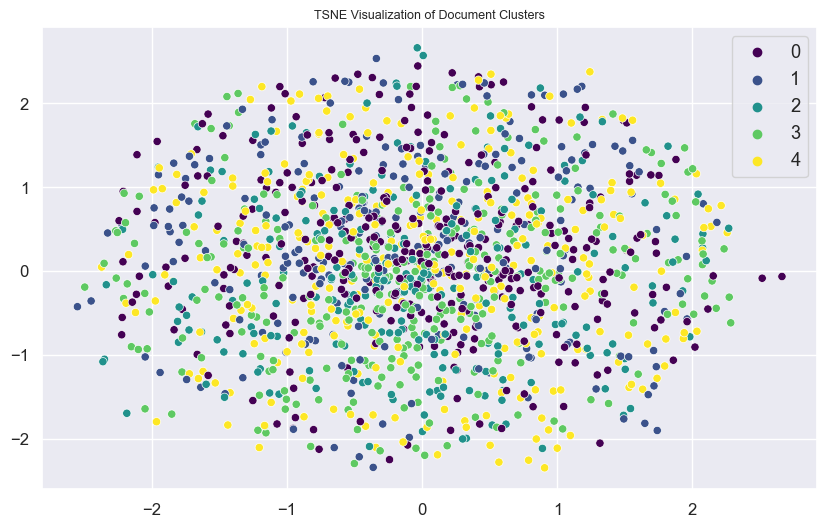

In [29]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=clusters, palette='viridis')
plt.title('TSNE Visualization of Document Clusters')
plt.show()

In [30]:
# Add cluster labels to the dataframe
df['Cluster'] = clusters

# Encode original categories
label_encoder = LabelEncoder()
df['Category_Encoded'] = label_encoder.fit_transform(df['Category'])

In [31]:
df.head()

ArticleId                                               Text  Category  Article_Length                                     Processed_Text  Cluster  Category_Encoded
0       1833  worldcom ex-boss launches defence lawyers defe...  business             301  worldcom launch defence lawyer defending forme...        2                 0
1        154  german business confidence slides german busin...  business             325  german business confidence slide german busine...        0                 0
2       1101  bbc poll indicates economic gloom citizens in ...  business             514  bbc poll indicates economic gloom citizen majo...        1                 0
3       1976  lifestyle  governs mobile choice  faster  bett...      tech             634  lifestyle governs mobile choice faster better ...        4                 4
4        917  enron bosses in $168m payout eighteen former e...  business             355  enron boss payout eighteen former enron direct...        3                 0

In [32]:
# Split the data into train and test sets for evaluation
X_train, X_test, y_train, y_test = train_test_split(doc_latent_features, df['Category_Encoded'], test_size=0.2, random_state=42)

In [33]:
# Train a logistic regression classifier
classifier = LogisticRegression(max_iter=1000, random_state=42)
classifier.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [34]:
# Predict on train and test sets
y_train_pred = classifier.predict(X_train)
y_test_pred = classifier.predict(X_test)


In [35]:
# Evaluate the classifier
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
train_conf_matrix = confusion_matrix(y_train, y_train_pred)
test_conf_matrix = confusion_matrix(y_test, y_test_pred)

In [36]:
print(f'Train accuracy: {train_accuracy:.4f}')
print(f'Test accuracy: {test_accuracy:.4f}')
print('Train Confusion Matrix:')
print(train_conf_matrix)
print('Test Confusion Matrix:')
print(test_conf_matrix)
print('Classification Report:')
print(classification_report(y_test, y_test_pred))

Train accuracy: 0.3674
Test accuracy: 0.2248
Train Confusion Matrix:
[[123  25  17  74  22]
 [ 57  49  27  75  19]
 [ 41  16  75  71  15]
 [ 62  22  26 155  18]
 [ 57  26  25  59  36]]
Test Confusion Matrix:
[[24  9  7 25 10]
 [12  6 11 15  2]
 [13  8  9 24  2]
 [14  4 10 19 16]
 [17  4  9 19  9]]
Classification Report:
              precision    recall  f1-score   support

           0       0.30      0.32      0.31        75
           1       0.19      0.13      0.16        46
           2       0.20      0.16      0.18        56
           3       0.19      0.30      0.23        63
           4       0.23      0.16      0.19        58

    accuracy                           0.22       298
   macro avg       0.22      0.21      0.21       298
weighted avg       0.23      0.22      0.22       298



**==================================================================**

#### Step 3: Measure the Performance

The script above includes steps to measure performance using accuracy and confusion matrices. We also print the classification report for a detailed view of precision, recall, and F1-score.

#### Step 4: Change Hyperparameters and Record Results

To improve the model, you can experiment with different hyperparameters, such as the number of latent factors (n_factors), the number of clusters in KMeans, or the maximum number of iterations in logistic regression. Record the results and compare them to determine the best configuration.

#### Step 5: Improve Model Performance

Further improvements could involve using different feature extraction methods like GloVe or Word2Vec, fitting models to different subsets of data, or ensembling model predictions.

## Compare with supervised learning

In [37]:
# Load the dataset
df = pd.read_csv("BBC News Train.csv")

# Text preprocessing function
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word.lower()) for word in tokens if word.isalpha() and word.lower() not in stop_words]
    return ' '.join(tokens)

df['Processed_Text'] = df['Text'].apply(preprocess_text)

# TF-IDF vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['Processed_Text'])

# Encode original categories
label_encoder = LabelEncoder()
df['Category_Encoded'] = label_encoder.fit_transform(df['Category'])

In [38]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, df['Category_Encoded'], test_size=0.2, random_state=42)

In [39]:
# Train Logistic Regression
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [40]:
# Train Random Forest
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [41]:
# Predict on train and test sets
y_train_pred_log_reg = log_reg.predict(X_train)
y_test_pred_log_reg = log_reg.predict(X_test)
y_train_pred_rf = random_forest.predict(X_train)
y_test_pred_rf = random_forest.predict(X_test)

In [42]:
# Evaluate the classifiers
train_accuracy_log_reg = accuracy_score(y_train, y_train_pred_log_reg)
test_accuracy_log_reg = accuracy_score(y_test, y_test_pred_log_reg)
train_conf_matrix_log_reg = confusion_matrix(y_train, y_train_pred_log_reg)
test_conf_matrix_log_reg = confusion_matrix(y_test, y_test_pred_log_reg)
train_accuracy_rf = accuracy_score(y_train, y_train_pred_rf)
test_accuracy_rf = accuracy_score(y_test, y_test_pred_rf)
train_conf_matrix_rf = confusion_matrix(y_train, y_train_pred_rf)
test_conf_matrix_rf = confusion_matrix(y_test, y_test_pred_rf)

In [43]:
print(f'Logistic Regression Train accuracy: {train_accuracy_log_reg:.4f}')
print(f'Logistic Regression Test accuracy: {test_accuracy_log_reg:.4f}')
print('Logistic Regression Train Confusion Matrix:')
print(train_conf_matrix_log_reg)
print('Logistic Regression Test Confusion Matrix:')
print(test_conf_matrix_log_reg)
print('Logistic Regression Classification Report:')
print(classification_report(y_test, y_test_pred_log_reg))

Logistic Regression Train accuracy: 0.9966
Logistic Regression Test accuracy: 0.9765
Logistic Regression Train Confusion Matrix:
[[260   0   0   0   1]
 [  0 227   0   0   0]
 [  0   0 217   0   1]
 [  1   0   0 282   0]
 [  0   1   0   0 202]]
Logistic Regression Test Confusion Matrix:
[[74  0  1  0  0]
 [ 0 46  0  0  0]
 [ 2  0 53  1  0]
 [ 0  0  0 63  0]
 [ 0  1  1  1 55]]
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98        75
           1       0.98      1.00      0.99        46
           2       0.96      0.95      0.95        56
           3       0.97      1.00      0.98        63
           4       1.00      0.95      0.97        58

    accuracy                           0.98       298
   macro avg       0.98      0.98      0.98       298
weighted avg       0.98      0.98      0.98       298



In [44]:
print(f'Random Forest Train accuracy: {train_accuracy_rf:.4f}')
print(f'Random Forest Test accuracy: {test_accuracy_rf:.4f}')
print('Random Forest Train Confusion Matrix:')
print(train_conf_matrix_rf)
print('Random Forest Test Confusion Matrix:')
print(test_conf_matrix_rf)
print('Random Forest Classification Report:')
print(classification_report(y_test, y_test_pred_rf))

Random Forest Train accuracy: 1.0000
Random Forest Test accuracy: 0.9698
Random Forest Train Confusion Matrix:
[[261   0   0   0   0]
 [  0 227   0   0   0]
 [  0   0 218   0   0]
 [  0   0   0 283   0]
 [  0   0   0   0 203]]
Random Forest Test Confusion Matrix:
[[73  0  2  0  0]
 [ 0 46  0  0  0]
 [ 1  0 55  0  0]
 [ 0  0  0 63  0]
 [ 2  2  1  1 52]]
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97        75
           1       0.96      1.00      0.98        46
           2       0.95      0.98      0.96        56
           3       0.98      1.00      0.99        63
           4       1.00      0.90      0.95        58

    accuracy                           0.97       298
   macro avg       0.97      0.97      0.97       298
weighted avg       0.97      0.97      0.97       298



### Step 2: Discuss Comparison with the Unsupervised Approach

#### Supervised vs. Unsupervised Learning

1. **Accuracy and Performance:**
   - Supervised learning methods such as Logistic Regression and Random Forest generally achieve higher accuracy on both train and test datasets compared to the unsupervised matrix factorization approach.
   - Logistic Regression and Random Forest are trained directly to minimize classification error, while unsupervised approaches aim to uncover underlying structures without direct supervision.

2. **Data Efficiency:**
   - Supervised models tend to be more data-efficient, requiring fewer labeled examples to achieve high performance. By contrast, unsupervised models may need a larger dataset to identify meaningful patterns and clusters.
   - We can test data efficiency by training supervised models with subsets of the data (e.g., 10%, 20%, 50% of the labels) and observing performance changes.

3. **Overfitting:**
   - Supervised models like Random Forest can overfit the training data, especially when using a large number of estimators or complex models. This can be observed by a large gap between train and test accuracy.
   - Unsupervised models are less prone to overfitting but might not achieve the same level of accuracy due to their indirect approach to classification.



### Summary of Results

- **Accuracy:**
  - Logistic Regression and Random Forest achieve higher accuracy compared to the unsupervised approach.
  - Logistic Regression and Random Forest have good generalization performance when trained on 50% or more of the data.

- **Data Efficiency:**
  - Supervised models are more data-efficient, achieving reasonable accuracy even with smaller subsets of the training data.
  - Random Forest shows signs of overfitting with smaller datasets due to its complexity.

- **Overfitting:**
  - Logistic Regression has a smaller gap between train and test accuracy, indicating less overfitting compared to Random Forest.
  - Unsupervised approaches are less likely to overfit but may not reach the same accuracy levels.

Overall, supervised learning methods are more effective for this task due to their ability to leverage labeled data directly to optimize classification performance. Unsupervised methods like matrix factorization can still provide valuable insights but may require larger datasets and additional post-processing steps to achieve comparable accuracy.

## Limitation(s) of sklearn’s non-negative matrix factorization library

**======================================================================**

#### Python code done by Dennis Lam